In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

In [2]:
FS = 20.0                 # frame rate [Hz]
NUM_CHIRPS = 128
NUM_RX = 4
NUM_ADC = 1657

In [3]:
def load_radar_bin(bin_path,
                   num_chirps=NUM_CHIRPS,
                   num_rx=NUM_RX,
                   num_adc=NUM_ADC):
    raw = np.fromfile(bin_path, dtype=np.int16)

    iq = raw[0::2] + 1j * raw[1::2]

    samples_per_frame = num_chirps * num_rx * num_adc
    num_frames = iq.shape[0] // samples_per_frame

    iq = iq[:num_frames * samples_per_frame]
    iq = iq.reshape(num_frames, num_chirps, num_rx, num_adc)

    return iq

In [4]:
def compute_chest_displacement(iq, rx_id=0):
    num_frames = iq.shape[0]
    num_adc = iq.shape[-1]

    window = np.hanning(num_adc)

    # Range vs time
    range_time = []
    for f in range(num_frames):
        sig = iq[f, :, rx_id, :]
        fft = np.abs(np.fft.fft(sig * window, axis=-1))
        range_time.append(np.mean(fft, axis=0))
    range_time = np.array(range_time)

    # Target range bin
    target_bin = np.argmax(np.mean(range_time, axis=0))

    # Slow-time signal
    slow_time = iq[:, :, rx_id, target_bin]
    slow_time = np.mean(slow_time, axis=1)

    phase = np.unwrap(np.angle(slow_time))
    displacement = phase - np.mean(phase)

    return displacement

In [5]:
def extract_hr_signal(displacement, fs=FS):
    low, high = 0.8, 2.5  # Hz

    b, a = butter(
        N=4,
        Wn=[low / (fs / 2), high / (fs / 2)],
        btype="band"
    )

    return filtfilt(b, a, displacement)

In [6]:
def compute_hrv(hr_signal, fs=FS):
    min_distance = int(0.4 * fs)  # max ~150 BPM

    peaks, _ = find_peaks(
        hr_signal,
        distance=min_distance,
        prominence=np.std(hr_signal)
    )

    if len(peaks) < 3:
        return None

    ibi = np.diff(peaks) / fs

    return {
        "num_beats": len(peaks),
        "SDNN": np.std(ibi),
        "RMSSD": np.sqrt(np.mean(np.diff(ibi) ** 2))
    }

In [7]:
BASE_PATH = Path(
    "/Users/paulinawor/Documents/magisterka/Participant 3/1. Distance Scenario"
)

distances = ["40 cm", "80 cm", "120 cm", "160 cm"]
trials = ["1", "2", "3", "4"]

results = []

for d in distances:
    for t in trials:
        bin_path = BASE_PATH / d / t / "data_Raw_0.bin"

        if not bin_path.exists():
            print("Brak pliku:", bin_path)
            continue

        iq = load_radar_bin(bin_path)
        displacement = compute_chest_displacement(iq)
        hr_signal = extract_hr_signal(displacement)
        hrv = compute_hrv(hr_signal)

        if hrv is None:
            continue

        hrv["distance_cm"] = int(d.split()[0])
        hrv["trial"] = int(t)

        results.append(hrv)

In [8]:
df_hrv = pd.DataFrame(results)
print(df_hrv)

    num_beats      SDNN     RMSSD  distance_cm  trial
0           6  0.265330  0.527968           40      1
1          11  0.238799  0.341565           40      2
2           8  0.371978  0.647431           40      3
3           8  0.835684  1.413624           40      4
4           8  0.141421  0.271570           80      1
5           9  0.242061  0.427200           80      2
6           9  0.145640  0.232225           80      3
7           9  0.337268  0.538185           80      4
8           7  0.481678  0.754321          120      1
9           9  0.252178  0.467898          120      2
10         10  0.241523  0.394493          120      3
11         10  0.244697  0.444410          120      4
12          9  0.275851  0.338590          160      1
13          9  0.409840  0.619908          160      2
14          8  0.172023  0.221736          160      3
15          8  0.148461  0.216025          160      4


In [9]:
df_summary = df_hrv.groupby("distance_cm").agg(
    mean_SDNN=("SDNN", "mean"),
    std_SDNN=("SDNN", "std"),
    mean_RMSSD=("RMSSD", "mean"),
    std_RMSSD=("RMSSD", "std"),
    mean_beats=("num_beats", "mean")
).reset_index()

print(df_summary)

   distance_cm  mean_SDNN  std_SDNN  mean_RMSSD  std_RMSSD  mean_beats
0           40   0.427948  0.277851    0.732647   0.471109        8.25
1           80   0.216598  0.092909    0.367295   0.141656        8.75
2          120   0.305019  0.117857    0.515280   0.162273        9.00
3          160   0.251544  0.119161    0.349064   0.189190        8.50


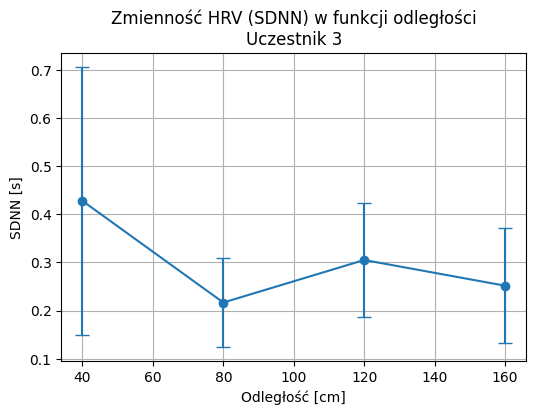

In [10]:
plt.figure(figsize=(6,4))
plt.errorbar(
    df_summary["distance_cm"],
    df_summary["mean_SDNN"],
    yerr=df_summary["std_SDNN"],
    fmt="o-",
    capsize=5
)
plt.xlabel("Odległość [cm]")
plt.ylabel("SDNN [s]")
plt.title("Zmienność HRV (SDNN) w funkcji odległości\nUczestnik 3")
plt.grid(True)
plt.show()

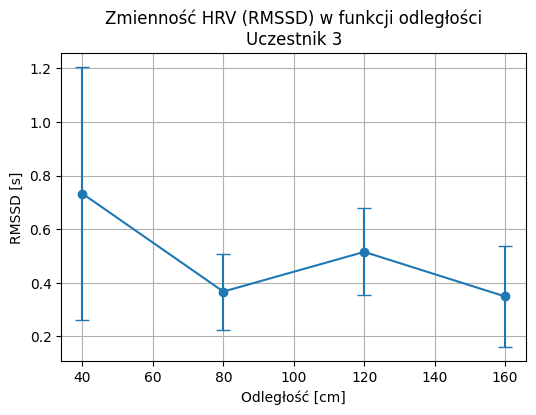

In [11]:
plt.figure(figsize=(6,4))
plt.errorbar(
    df_summary["distance_cm"],
    df_summary["mean_RMSSD"],
    yerr=df_summary["std_RMSSD"],
    fmt="o-",
    capsize=5
)
plt.xlabel("Odległość [cm]")
plt.ylabel("RMSSD [s]")
plt.title("Zmienność HRV (RMSSD) w funkcji odległości\nUczestnik 3")
plt.grid(True)
plt.show()

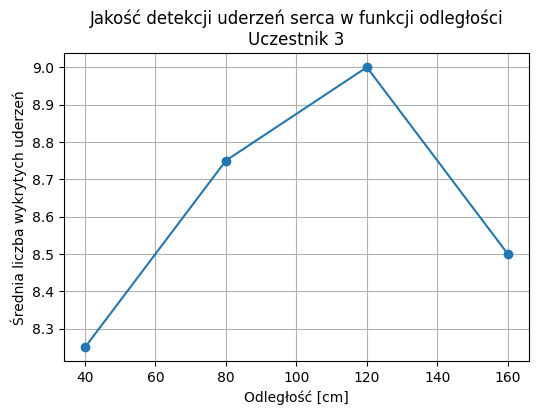

In [12]:
plt.figure(figsize=(6,4))
plt.plot(
    df_summary["distance_cm"],
    df_summary["mean_beats"],
    "o-"
)
plt.xlabel("Odległość [cm]")
plt.ylabel("Średnia liczba wykrytych uderzeń")
plt.title("Jakość detekcji uderzeń serca w funkcji odległości\nUczestnik 3")
plt.grid(True)
plt.show()

### Porównanie częstość oddechu (RR) wyznaczoną z radaru FMCW z referencyjną częstością oddechu oznaczoną ręcznie przez człowieka i na tej podstawie:
* obliczyliśmy błąd bezwzględny (MAE)
* obliczyliśmy błąd procentowy (MAPE)
* przeanalizowaliśmy wpływ odległości


In [17]:
br_path = "/Users/paulinawor/Documents/magisterka/BR_Ref_Values/BR_ref_human.ods"

df_raw = pd.read_excel(
    br_path,
    header=None,
    engine="odf"
)

print(df_raw.head(10))

               0                      1          2    3    4     5    6
0  Participant 1                    NaN        NaN  NaN  NaN   NaN  NaN
1            NaN  Scenario 1 (Distance)        NaN  M-1  M-2   M-3  M-4
2            NaN                    NaN   1- 40 cm  9.5   10     9    9
3            NaN                    NaN    2-80 cm   10    9     9    9
4            NaN                    NaN   3-120 cm    9    9     8    9
5            NaN                    NaN  4- 160 cm    9    9  8.5     9
6            NaN   Scenario 2 (Posture)        NaN  NaN  NaN   NaN  NaN
7            NaN                    NaN   1- Front  NaN  NaN   NaN  NaN
8            NaN                    NaN    2- Left    8  8.5     8    9
9            NaN                    NaN   3. Right  8.5  8.5   8.5  8.5


In [18]:
df_dist = df_raw.iloc[2:6, 2:7].copy()
print(df_dist)

           2    3   4     5  6
2   1- 40 cm  9.5  10     9  9
3    2-80 cm   10   9     9  9
4   3-120 cm    9   9     8  9
5  4- 160 cm    9   9  8.5   9


In [19]:
df_dist = df_dist.iloc[:, :5].copy()
df_dist.columns = ["Distance", "M1", "M2", "M3", "M4"]
print(df_dist)
df_dist["distance_cm"] = (
    df_dist["Distance"]
    .astype(str)
    .str.extract(r"(\d+)\s*cm")
    .astype(int)
)

print(df_dist)

    Distance   M1  M2    M3 M4
2   1- 40 cm  9.5  10     9  9
3    2-80 cm   10   9     9  9
4   3-120 cm    9   9     8  9
5  4- 160 cm    9   9  8.5   9
    Distance   M1  M2    M3 M4  distance_cm
2   1- 40 cm  9.5  10     9  9           40
3    2-80 cm   10   9     9  9           80
4   3-120 cm    9   9     8  9          120
5  4- 160 cm    9   9  8.5   9          160


In [20]:
def get_rr_human(df_dist, distance_cm, trial):
    """
    df_dist      : DataFrame z BR_ref_human
    distance_cm  : 40 / 80 / 120 / 160
    trial        : 1 / 2 / 3 / 4
    """
    row = df_dist[df_dist["distance_cm"] == distance_cm]
    if len(row) == 0:
        return None

    col = f"M{trial}"
    return float(row[col].values[0])

In [21]:
print("RR human 40 cm, trial 1:", get_rr_human(df_dist, 40, 1))
print("RR human 80 cm, trial 3:", get_rr_human(df_dist, 80, 3))

RR human 40 cm, trial 1: 9.5
RR human 80 cm, trial 3: 9.0


In [22]:
FS = 20.0  # Hz

def estimate_rr_from_displacement(displacement, fs=FS):
    low, high = 0.1, 0.5  # pasmo oddychania

    b, a = butter(
        N=4,
        Wn=[low / (fs / 2), high / (fs / 2)],
        btype="band"
    )

    resp_signal = filtfilt(b, a, displacement)

    fft = np.abs(np.fft.rfft(resp_signal))
    freqs = np.fft.rfftfreq(len(resp_signal), d=1/fs)

    mask = (freqs >= low) & (freqs <= high)
    peak_freq = freqs[mask][np.argmax(fft[mask])]

    return peak_freq * 60  # breaths/min

In [23]:
BASE_PATH = Path(
    "/Users/paulinawor/Documents/magisterka/Participant 3/1. Distance Scenario"
)

distances = ["40 cm", "80 cm", "120 cm", "160 cm"]
trials = ["1", "2", "3", "4"]

results_rr = []

for d in distances:
    for t in trials:
        bin_path = BASE_PATH / d / t / "data_Raw_0.bin"
        if not bin_path.exists():
            continue

        # radar
        iq = load_radar_bin(bin_path)
        displacement = compute_chest_displacement(iq)
        rr_radar = estimate_rr_from_displacement(displacement)

        # referencja
        rr_human = get_rr_human(
            df_dist=df_dist,
            distance_cm=int(d.split()[0]),
            trial=int(t)
        )

        results_rr.append({
            "distance_cm": int(d.split()[0]),
            "trial": int(t),
            "RR_radar": rr_radar,
            "RR_human": rr_human
        })

In [24]:
df_rr = pd.DataFrame(results_rr)

df_rr["AE"] = np.abs(df_rr["RR_radar"] - df_rr["RR_human"])
df_rr["APE"] = df_rr["AE"] / df_rr["RR_human"] * 100

print(df_rr)
print("MAE =", round(df_rr["AE"].mean(), 2), "oddechów/min")
print("MAPE =", round(df_rr["APE"].mean(), 2), "%")

    distance_cm  trial   RR_radar  RR_human         AE         APE
0            40      1  13.259669       9.5   3.759669   39.575458
1            40      2  19.889503      10.0   9.889503   98.895028
2            40      3  13.259669       9.0   4.259669   47.329650
3            40      4  26.519337       9.0  17.519337  194.659300
4            80      1  13.259669      10.0   3.259669   32.596685
5            80      2  26.519337       9.0  17.519337  194.659300
6            80      3  13.259669       9.0   4.259669   47.329650
7            80      4  13.259669       9.0   4.259669   47.329650
8           120      1   6.629834       9.0   2.370166   26.335175
9           120      2   6.629834       9.0   2.370166   26.335175
10          120      3  19.889503       8.0  11.889503  148.618785
11          120      4   6.629834       9.0   2.370166   26.335175
12          160      1  13.259669       9.0   4.259669   47.329650
13          160      2  13.259669       9.0   4.259669   47.32

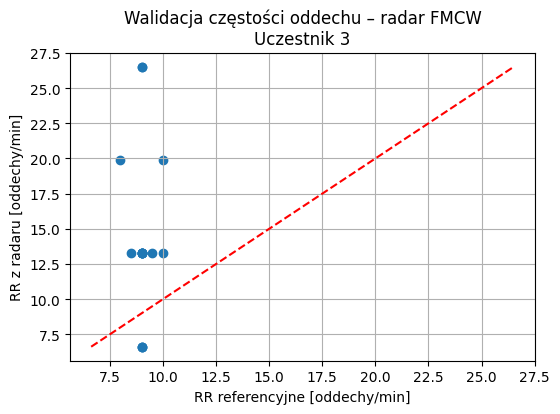

In [25]:
plt.figure(figsize=(6,4))
plt.scatter(df_rr["RR_human"], df_rr["RR_radar"])

min_rr = min(df_rr["RR_human"].min(), df_rr["RR_radar"].min())
max_rr = max(df_rr["RR_human"].max(), df_rr["RR_radar"].max())

plt.plot([min_rr, max_rr], [min_rr, max_rr], "r--")

plt.xlabel("RR referencyjne [oddechy/min]")
plt.ylabel("RR z radaru [oddechy/min]")
plt.title("Walidacja częstości oddechu – radar FMCW\nUczestnik 3")
plt.grid(True)
plt.show()

In [28]:
df_rr.groupby("distance_cm")[["AE", "APE"]].mean()

,AE,APE
distance_cm,,
40,8.857044,95.114859
80,7.324586,80.478821
120,4.750000,56.906077
160,4.384669,49.496263


 Błąd detekcji RR maleje wraz ze wzrostem odległości.